In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
from scipy.stats import linregress
import tkinter as tk
import datetime as dt
import matplotlib
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

c:\users\ryan\appdata\local\programs\python\python38\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [8]:
class Application(tk.Frame):
    def __init__(self, master=None):
        super().__init__(master)
        self.master = master
        self.pack()
        self.create_widgets()
        
        self.symbols = None
        self.portfolio = None
        
    def create_widgets(self):
        # labels
        tk.Label(self, text="Symbols (comma-separated)").grid(row=0)
        tk.Label(self, text="Weights (comma-separated)").grid(row=1)
        tk.Label(self, text="Start Date (yyyy-mm-dd)").grid(row=2)
        tk.Label(self, text="End Date (yyyy-mm-dd)").grid(row=3)
        tk.Label(self, text="Initial Contribution $").grid(row=4)
        tk.Label(self, text="Monthly Contribution $").grid(row=5)

        # input symbols
        self.input_symbols = tk.Entry(self)
        self.input_symbols.grid(row=0, column=1)
        
        # input weights
        self.input_weights = tk.Entry(self)
        self.input_weights.grid(row=1, column=1)
        
        # start date
        self.start_date = tk.Entry(self)
        self.start_date.grid(row=2, column=1)
        
        # end date
        self.end_date = tk.Entry(self)
        self.end_date.grid(row=3, column=1)
        
        # initial contribution
        self.initial = tk.Entry(self)
        self.initial.grid(row=4, column=1)

        # monthly contribution
        self.contrib = tk.Entry(self)
        self.contrib.grid(row=5, column=1)
        
        # submit button
        self.submit = tk.Button(self, text="SUBMIT", fg="red", command=self.run_analysis).grid(row=6, column=0)

        self.input_symbols.insert("10", "SPY, QQQ")
        self.input_weights.insert("10", ".5, .5")
        self.start_date.insert("10", "1990-01-01")
        self.end_date.insert("10", "2020-01-01")
        self.initial.insert("10", "1000")
        self.contrib.insert("10", "100")
        self.error = tk.Message(self, text="")
        self.error.grid(row=10)
        

    def run_analysis(self):
        # gather input data
        symbols = [ el.strip().upper() for el in self.input_symbols.get().split(",") ]
        weights = [ float(el.strip()) for el in self.input_weights.get().split(",") ]
        start_date = self.start_date.get().strip()
        end_date = self.end_date.get().strip()
        init = float(self.initial.get().strip())
        contrib = float(self.contrib.get().strip())
        
        # get porfolio prices (if new input)
        if symbols != self.symbols: # no need to regather data if symbols are the same
            print("Gathering new stock data")
            self.portfolio = self.getClosingPrices(symbols, start_date, end_date)
            self.symbols = symbols
        else:
            print("Using previous data")
            
        # error checking
        if len(weights) != self.portfolio.shape[1]:
            print("Error, unequal inputs")
            self.displayError("Number of symbols and weights do not match")
            return
        self.clearError()
            
        # get portfolio segment from input dates
        start = [ int(el) for el in start_date.split("-") ]
        start_date = self.portfolio.index.searchsorted(dt.datetime(start[0], start[1], start[2]))
        end = [ int(el) for el in end_date.split("-") ]
        end_date = self.portfolio.index.searchsorted(dt.datetime(end[0], end[1], end[2]))
        portfolio = self.portfolio.iloc[start_date:end_date]
                
        # get returns
        returns = self.getReturns(portfolio)

        # get total risk over time
        total_static_risk = self.calcTotalRisk(init, 0, portfolio)
        total_continuous_risk = self.calcTotalRisk(init, contrib, portfolio)
        
        # get total returns over time
        total_static_returns = self.calcTotalReturns(init, 0, weights, returns)
        total_continuous_returns = self.calcTotalReturns(init, contrib, weights, returns)
        
        self.displayGraph(total_static_risk, total_static_returns, total_continuous_risk, total_continuous_returns, returns.index)
        
        
    def getClosingPrices(self, tickers, start_date, end_date):
        """Get the closing prices of tickers as dataframe (remove null rows)"""
        portfolio = pd.DataFrame()
        for ticker in tickers:
            portfolio[ticker] = pdr.get_data_yahoo(ticker, start_date, end_date, interval="m").Close # change interval here when changing INTERVAL
        return portfolio.dropna()
        
    
    def getReturns(self, prices_df):
        """Calculate the returns of the price dataframe"""
        shift = np.array(prices_df)[1:, :] - np.array(prices_df)[:-1,:]
        returns = pd.DataFrame(np.divide(shift, np.array(prices_df)[:-1,:]) + 1, columns = prices_df.columns)
        returns.index = prices_df.index[:-1]
        return returns
    
    
    def calcTotalRisk(self, init, contrib, portfolio):
        """Get list of risk over time"""
        return [ init + contrib * i for i in range(portfolio.shape[0]-1) ]

    
    def calcTotalReturns(self, init, contrib, weights, returns_df):
        returns = {}
        for i in range(returns_df.shape[1]):
            ticker = returns_df.columns[i]
            t_returns = returns_df[ticker]
            returns[ticker] = ( self.calcReturns(init*weights[i], contrib*weights[i], t_returns) )
        return np.array(pd.DataFrame(returns)).sum(axis=1)
    
    
    def calcReturns(self, init, contrib, pct_changes):
        """Get list of returns over time"""
        returns = []
        for i in range(len(pct_changes)):
            returns.append( ( returns[i-1] + contrib ) * pct_changes[i] if i > 0 else init * pct_changes[0] )
        return returns

    
    def displayGraph(self, static_risk, static_returns, continuous_risk, continuous_returns, xticks):
        fig = Figure(figsize=(5,4))
        a = fig.add_subplot(111)
        a.plot(xticks, static_risk, "y--")
        a.plot(xticks, static_returns, "y-")
        a.plot(xticks, continuous_risk, "b--")
        a.plot(xticks, continuous_returns, "b-")
        a.set_title("Risk vs Returns of Portfolio")
        a.set_ylabel("$")
        a.set_xlabel("Time")

        canvas = FigureCanvasTkAgg(fig, master=self)
        canvas.get_tk_widget().grid(row=7)
        canvas.draw()
        
    def displayError(self, msg):
        self.error.configure(text=msg)
        
    def clearError(self):
        self.error.configure(text="")

        
        
root = tk.Tk()
app = Application(master=root)
app.mainloop()

In [40]:
PORTFOLIO_TICKERS = [ "QQQ" ]
PORTFOLIO_WEIGHTS = [ 1 ]

## Stock Data

In [41]:
START = "1970-01-01"
END = "2020-01-01"
PORTFOLIO = pd.DataFrame()

for ticker in PORTFOLIO_TICKERS:
    PORTFOLIO[ticker] = pdr.get_data_yahoo(ticker, START, END, interval="m").Close # change interval here when changing INTERVAL
    
PORTFOLIO = PORTFOLIO.dropna()

# SET PARAMS

In [42]:
NUM_YEARS = 20
INITIAL = 1000
CONTRIB = 100
INTERVAL = "month"

### Get params

In [43]:
divisors = {
    "day": 253,
    "month": 12
}
divisor = divisors[INTERVAL]


daily_change = np.array(PORTFOLIO)[1:,:] - np.array(PORTFOLIO)[:-1,:]
pct_change = np.divide( daily_change, np.array(PORTFOLIO)[:-1, :] ) + 1

pct_change_df = pd.DataFrame( dict( (PORTFOLIO_TICKERS[i], pct_change[:,i]) for i in range(len(PORTFOLIO_TICKERS)) ) )
pct_change_df.index = PORTFOLIO.index[:-1]
pct_change_df = pct_change_df.iloc[:NUM_YEARS * divisor, :]
time_len = pct_change_df.shape[0]

In [44]:
def calcRisk(init, contrib, time):
    return [ init + contrib * i for i in range(time) ]

def calcReturns(init, contrib, pct_changes):
    returns = []
    for i in range(len(pct_changes)):
        returns.append( ( returns[i-1] + contrib ) * pct_changes[i] if i > 0 else init * pct_changes[0] )
    return returns

# One Time Investment

In [45]:
# get risk over time
one_time_risk = calcRisk(INITIAL, 0, time_len)

# get returns over time
one_time_returns = pd.DataFrame( dict( ( PORTFOLIO_TICKERS[i], calcReturns(INITIAL * PORTFOLIO_WEIGHTS[i], 0, pct_change_df[PORTFOLIO_TICKERS[i]]) ) for i in range(len(PORTFOLIO_TICKERS)) ) )
one_time_returns.index = pct_change_df.index

# sum of returns
one_time_total_returns = one_time_returns.sum(axis=1)

# net gains
net_gains = one_time_total_returns[-1]-one_time_risk[-1]

print("Total returns from one initial investment of {} after {} years: ${}".format(INITIAL, one_time_returns.shape[0]/divisor, one_time_total_returns[-1]))
print("Total risk: ${}".format(one_time_risk[-1]))
print("Net gains: ${} -> {}".format(net_gains, net_gains/one_time_risk[-1]+1))

Total returns from one initial investment of 1000 after 20.0 years: $3424.1334825416966
Total risk: $1000
Net gains: $2424.1334825416966 -> 3.4241334825416967


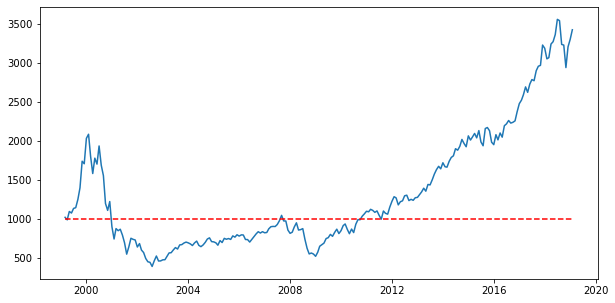

In [46]:
plt.figure(figsize=(10,5))
plt.plot(one_time_total_returns)
plt.plot(one_time_total_returns.index, one_time_risk, "r--")
plt.show()

# CONTINUOUS INVESTMENT

In [47]:
# get risk over time
continuous_risk = calcRisk(INITIAL, CONTRIB, time_len)

# get returns over time
continuous_returns = pd.DataFrame( dict( ( PORTFOLIO_TICKERS[i], calcReturns(INITIAL*PORTFOLIO_WEIGHTS[i], CONTRIB*PORTFOLIO_WEIGHTS[i], pct_change_df[PORTFOLIO_TICKERS[i]]) )
                                        for i in range(len(PORTFOLIO_TICKERS)) ) )
continuous_returns.index = pct_change_df.index

# sum of returns
continuous_total_returns = continuous_returns.sum(axis=1)

# net gains
net_gains = continuous_total_returns[-1]-continuous_risk[-1]

print("Total returns from one initial investment of ${} with ${}/{} contribution after {} years: ${}".format(INITIAL, CONTRIB, INTERVAL, continuous_returns.shape[0]/divisor, continuous_total_returns[-1]))
print("Total risk: ${}".format(continuous_risk[-1]))
print("Net gains: ${} -> {}".format(net_gains, net_gains/continuous_risk[-1]+1))

Total returns from one initial investment of $1000 with $100/month contribution after 20.0 years: $85349.97923634147
Total risk: $24900
Net gains: $60449.979236341474 -> 3.4277100094916255


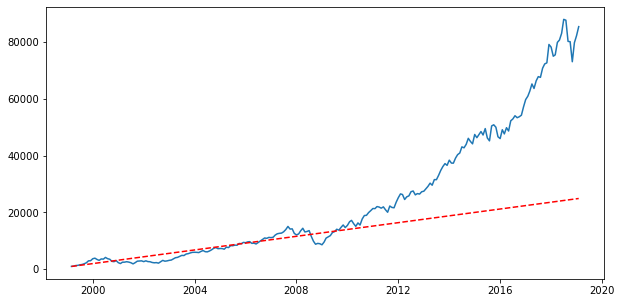

In [48]:
plt.figure(figsize=(10,5))
plt.plot(continuous_total_returns)
plt.plot(continuous_total_returns.index, continuous_risk, "r--")
plt.show()

# COMPARISON

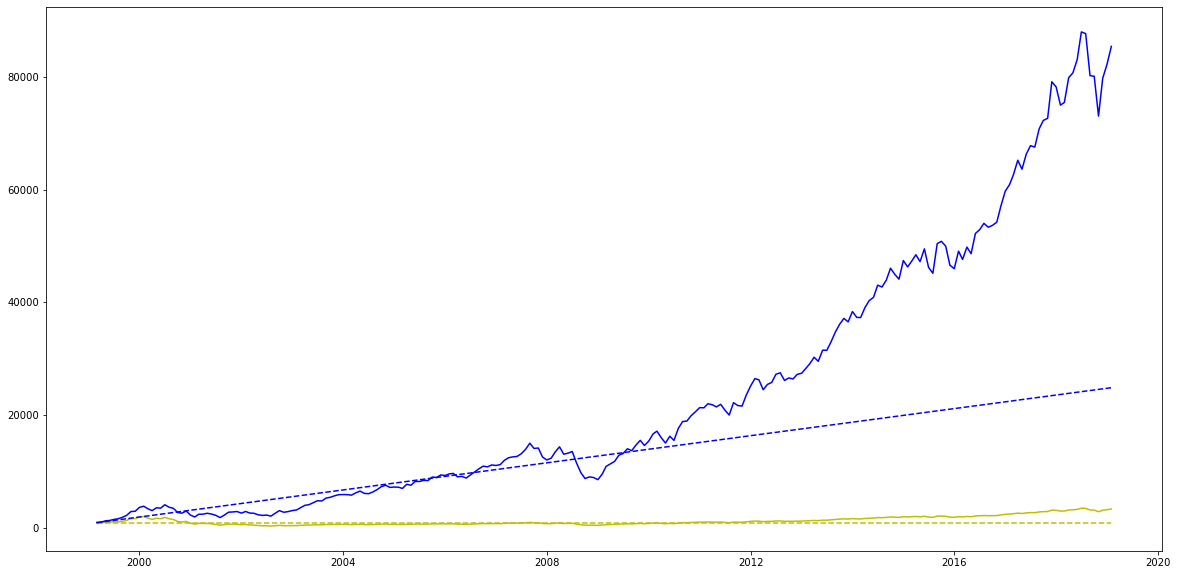

In [49]:
xticks = one_time_total_returns.index
plt.figure(figsize=(20,10)) 
plt.plot(xticks, one_time_total_returns, "y-")
plt.plot(xticks, one_time_risk, "y--")
plt.plot(xticks, continuous_total_returns, "b-")
plt.plot(xticks, continuous_risk, "b--")
plt.show()